In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import folium # map rendering library
from folium.features import DivIcon #used to add popup info to a map
import shapely
from shapely.geometry import Point, Polygon
import shapefile # install pyshp first if you get a ModuleNotFoundError
import sklearn
from sklearn.cluster import KMeans

## JNB Lab Solutions

### Park District Facilities

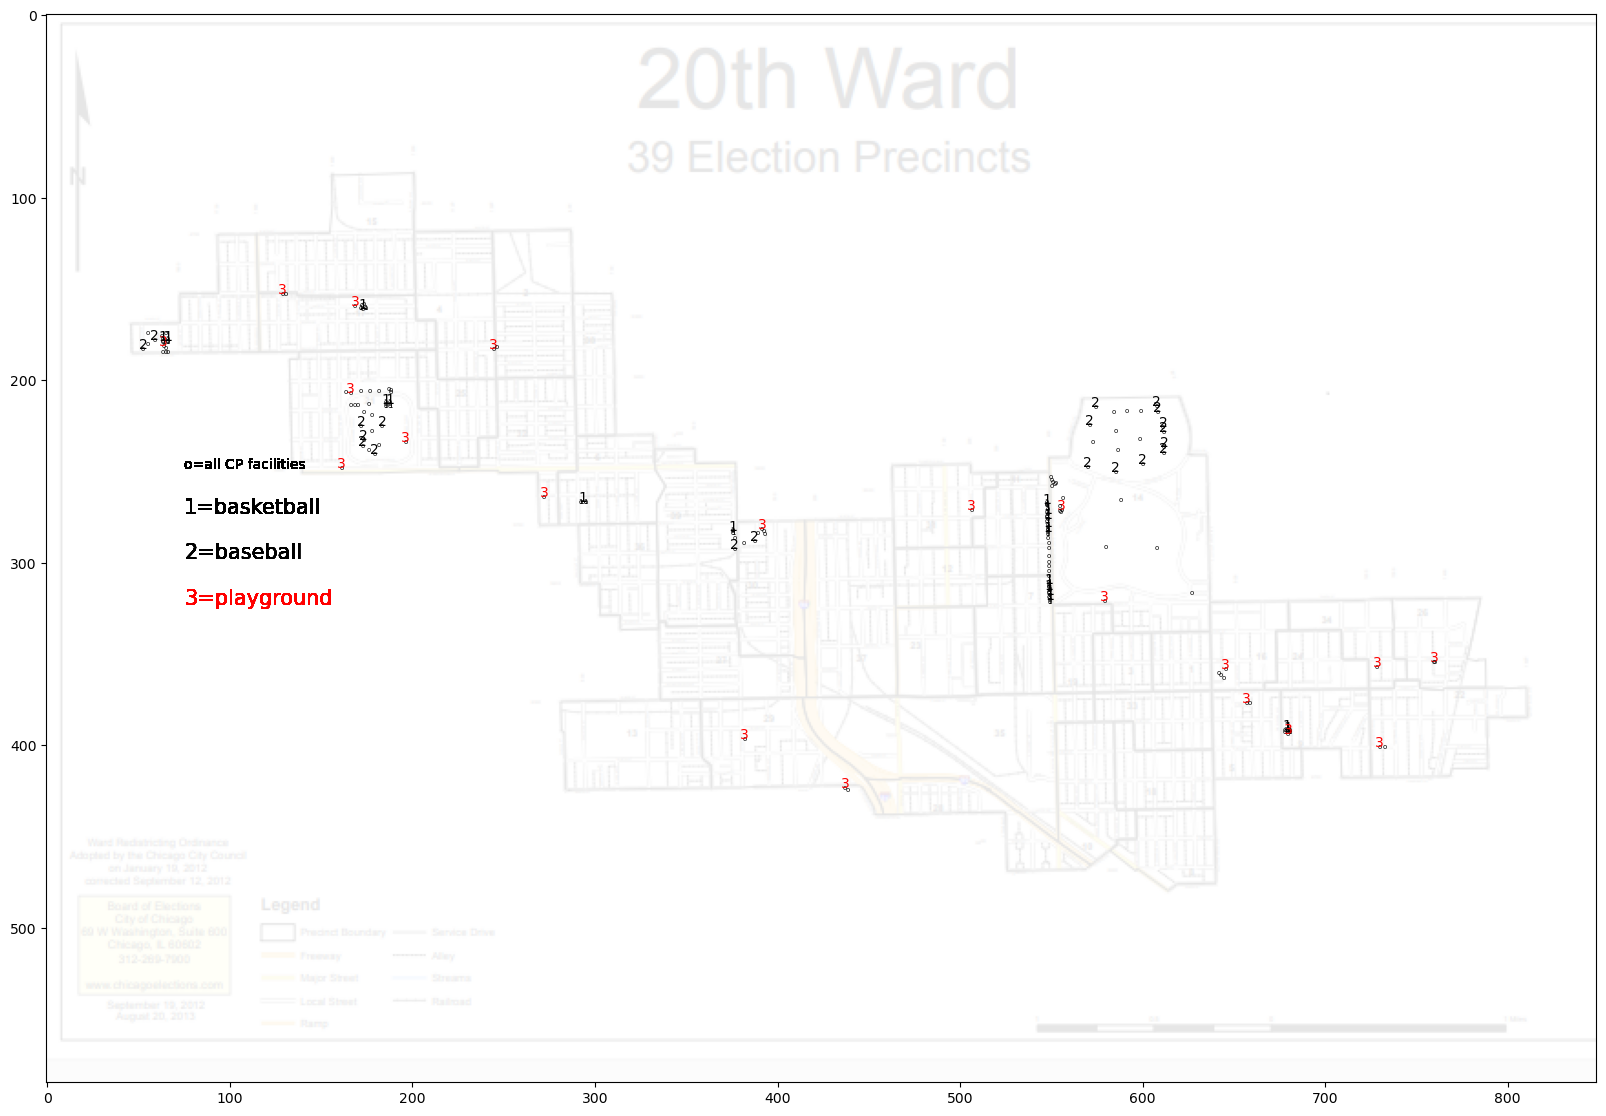

In [9]:
img = Image.open("ward20.png")
#Function to convert (lat,lon) to (x,y) location on the Ward 20 map
def coord(lat,lon):
    minlon=-87.672079
    maxlon=-87.586493
    xmin=47
    xmax=806
    x=xmin+(lon-minlon)*(xmax-xmin)/(maxlon-minlon)
    minlat=41.778798
    maxlat=41.801243
    ymax=189
    ymin=389
    y=ymin+(lat-minlat)*(ymax-ymin)/(maxlat-minlat)
    return x,y
sf = shapefile.Reader("ward20.shp")
shapes=sf.shapes()
parks=pd.read_json("https://data.cityofchicago.org/resource/eix4-gf83.json?$limit=400000")
p=parks[["facility_n","facility_t","x_coord","y_coord"]]
p.columns=["type","loc","longitude","latitude"]
plt.figure(figsize=(20,16))
plt.imshow(img,alpha=.1)
df=p

#use this format
for i in df.index:
    [x,y]=coord(df.loc[i,"latitude"],df.loc[i,"longitude"])
    point=Point(df.loc[i,"longitude"],df.loc[i,"latitude"])
    if point.within(Polygon(shapes[3].points)):
        plt.text(x,y,"o",color='black',size=5,ha='center',va='bottom')
        plt.text(75,250,"o=all CP facilities",color='black',size=10,ha='left',va='bottom')
        if df.loc[i,"type"]=="BASKETBALL BACKBOARD":
            plt.text(x,y,"1",color='black',size=5,ha='center',va='bottom')
            plt.text(75,275,"1=basketball",color='black',size=15,ha='left',va='bottom')
        if df.loc[i,"type"]=="BASKETBALL COURT":
            plt.text(x,y,"1",color='black',size=10,ha='center',va='bottom')
        if df.loc[i,"type"]=="BASEBALL JR/SOFTBALL":
            plt.text(x,y,"2",color='black',size=10,ha='center',va='bottom')
            plt.text(75,300,"2=baseball",color='black',size=15,ha='left',va='bottom')
        if df.loc[i,"type"]=="BASEBALL SR":
            plt.text(x,y,"2",color='black',size=10,ha='center',va='bottom')
        if df.loc[i,"type"]=="PLAYGROUND":  
            plt.text(x,y,"3",color='red',size=10,ha='center',va='bottom')
            plt.text(75,325,"3=playground",color='red',size=15,ha='left',va='bottom')
plt.show()

### Tax Year 2019 Owner-Occupied Tax Sale Data for Ward 20

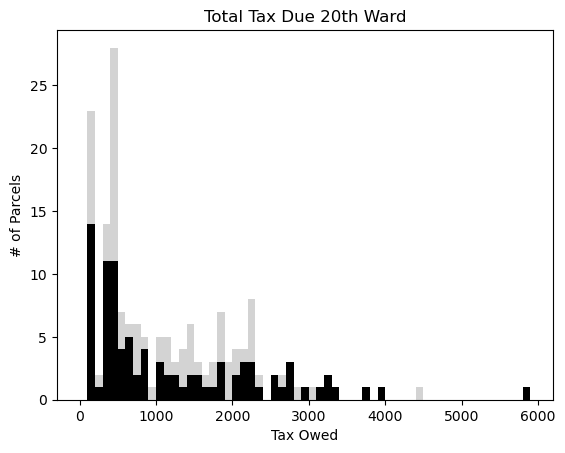

In [10]:
df=pd.read_excel("Ward20residentialparcels.xlsx")
df2=pd.read_excel("HEIcandidateparcels.xlsx")
# plotting first histogram
df["Total Tax Due"].hist(grid=False, bins=range(0,6000,100),color='lightgray')
# plotting second histogram
df2["Total Tax Due"].hist(grid=False, bins=range(0,6000,100),color='black')
plt.xlabel('Tax Owed')
plt.ylabel('# of Parcels')
 
plt.title('Total Tax Due 20th Ward')
plt.savefig("TS2019rev.png")
# Showing the plot using plt.show()
plt.show()


### Low Income Tract Clustering

3a) Read in census tract data.

In [5]:
rawdf=pd.read_csv("tract_covariates.csv")
IL=rawdf[rawdf['state']== 17]
cook=IL[IL['county']==31]
low_inc=cook[cook['med_hhinc2016']<30000]
df=low_inc[['tract','emp2000', 'frac_coll_plus2010','job_density_2013',   'mean_commutetime2000', 'med_hhinc2016','popdensity2010', 'rent_twobed2015','singleparent_share2010']] 
df.columns=['Tract','emp','college','jobdensity','commute','hhincome','popdensity','rent','singleparent']
df.loc[:, 'work'] = df.loc[:, 'jobdensity'] / df.loc[:, 'popdensity']
df.loc[:, 'room'] = df.loc[:, 'rent'] / df.loc[:, 'hhincome']
df=df.dropna()
 # normalize values
Mwork=df["work"].max()
mwork=df["work"].min()
Mroom=df["room"].max()
mroom=df["room"].min()
Msingleparent=df["singleparent"].max()
msingleparent=df["singleparent"].min()
Mcommute=df["commute"].max()
mcommute=df["commute"].min()
Mcollege=df["college"].max()
mcollege=df["college"].min()
Mhhincome=df["hhincome"].max()
mhhincome=df["hhincome"].min()
df.loc[:,"work"]=(df.loc[:,"work"]-mwork)/(Mwork-mwork)
df.loc[:,"room"]=(df.loc[:,"room"]-mroom)/(Mroom-mroom)
df.loc[:,"singleparent"]=(df.loc[:,"singleparent"]-msingleparent)/(Msingleparent-msingleparent)
df.loc[:,"commute"]=(df.loc[:,"commute"]-mcommute)/(Mcommute-mcommute)
df.loc[:,"education"]=(df.loc[:,"college"]-mcollege)/(Mcollege-mcollege)
df.loc[:,"income"]=(df.loc[:,"hhincome"]-mhhincome)/(Mhhincome-mhhincome)

/var/folders/7b/cxqkjv5514q19434nrk5rx0r0000gp/T/ipykernel_1268/83952099.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'work'] = df.loc[:, 'jobdensity'] / df.loc[:, 'popdensity']
/var/folders/7b/cxqkjv5514q19434nrk5rx0r0000gp/T/ipykernel_1268/83952099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'room'] = df.loc[:, 'rent'] / df.loc[:, 'hhincome']


<Figure size 1000x600 with 0 Axes>

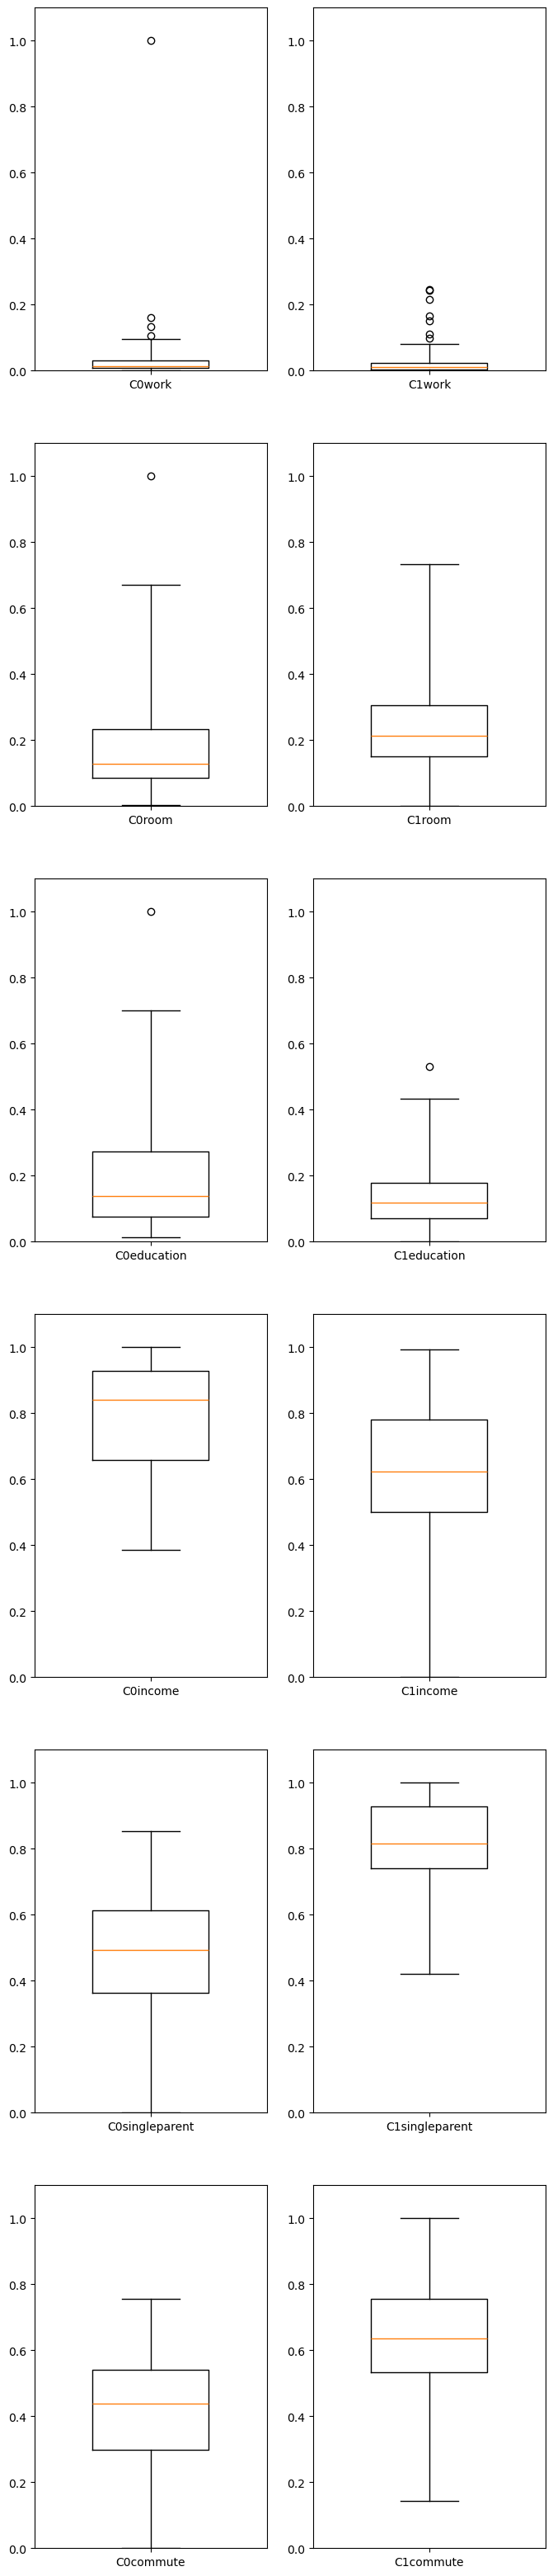

In [6]:
tracts=df[["Tract","work","room","education","income","singleparent","commute"]]
tracts=tracts.dropna()
cols=["work","room","education","income","singleparent","commute"]
tractcluster=tracts[cols]
# Fit the k means model
k_means = KMeans(init="k-means++", n_clusters=2, n_init=2)
k_means.fit(tractcluster)
#Get Labels
k_means_labels = k_means.labels_
k_means_labels
tracts["CLASS"]=k_means_labels
tracts=tracts.reset_index(drop=True)
tracts.head(2)
C0=tracts[tracts["CLASS"]==0]
C0.head(1)
C1=tracts[tracts["CLASS"]==1]
C1.head(1)
numplots=len(cols)
plt.figure(figsize=[10,numplots])
fig, axes = plt.subplots(numplots,2,figsize=[8,40])
for i in np.arange(0,numplots,1):
    axes[i,0].set_ylim((0,1.1))
    axes[i,1].set_ylim((0,1.1))
    axes[i,0].boxplot(C0[cols[i]],whis=3,labels=['C0'+cols[i]],widths=.5)
    axes[i,1].boxplot(C1[cols[i]],whis=3,labels=['C1'+cols[i]],widths=.5)
plt.show()

<Figure size 1000x600 with 0 Axes>

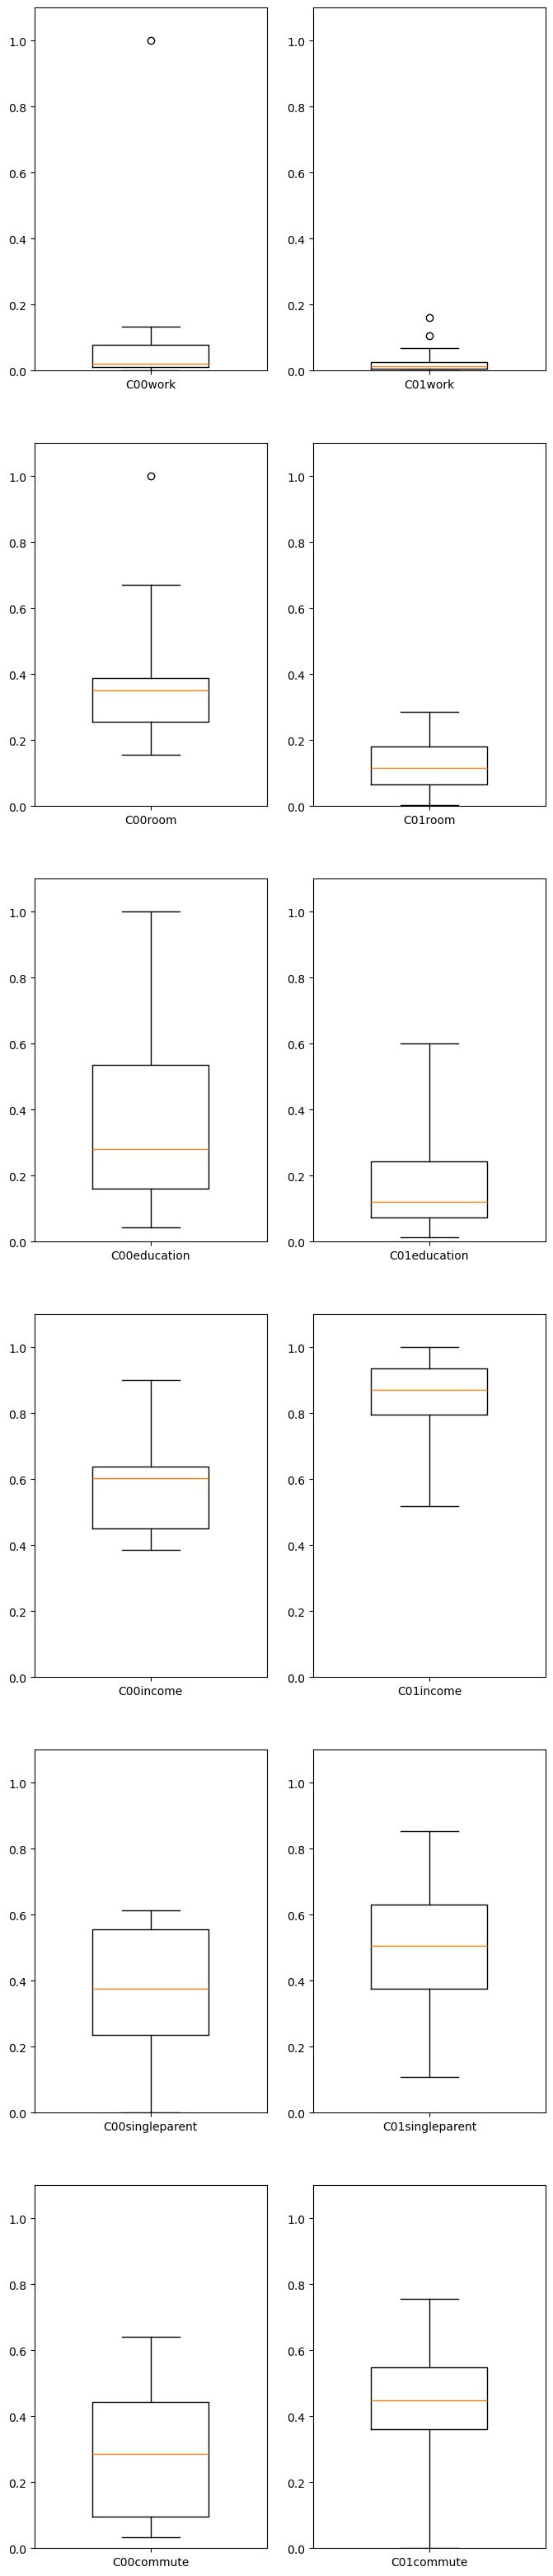

In [7]:
tracts=C0[["Tract","work","room","education","income","singleparent","commute"]]
tracts=tracts.dropna()
cols=["work","room","education","income","singleparent","commute"]
tractcluster=tracts[cols]
# Fit the k means model
k_means = KMeans(init="k-means++", n_clusters=2, n_init=2)
k_means.fit(tractcluster)
#Get Labels
k_means_labels = k_means.labels_
k_means_labels
tracts["CLASS"]=k_means_labels
tracts=tracts.reset_index(drop=True)
tracts.head(2)
C00=tracts[tracts["CLASS"]==0]
C01=tracts[tracts["CLASS"]==1]
numplots=len(cols)
plt.figure(figsize=[10,numplots])
fig, axes = plt.subplots(numplots,2,figsize=[8,40])
for i in np.arange(0,numplots,1):
    axes[i,0].set_ylim((0,1.1))
    axes[i,1].set_ylim((0,1.1))
    axes[i,0].boxplot(C00[cols[i]],whis=3,labels=['C00'+cols[i]],widths=.5)
    axes[i,1].boxplot(C01[cols[i]],whis=3,labels=['C01'+cols[i]],widths=.5)
plt.show()